
# Xarray / Intake example
## synopsis: decadenal mean of precipitation of 2 scenarios
## dependencies: xarray, cartopy, matplotlib, intake


In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import intake

In [2]:
# intake mistral pr data
url="/work/ik1017/Catalogs/mistral-cmip6.json"
#url="/work/ik1017/Catalogs/mistral-cmip5.json"

col=intake.open_esm_datastore(url)
col.df.head(3)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
0,AerChemMIP,HAMMOZ-Consortium,MPI-ESM-1-2-HAM,ssp370-lowNTCF,r1i1p1f1,Lmon,npp,gn,NaN,v20190627,203501-205412,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...
1,AerChemMIP,HAMMOZ-Consortium,MPI-ESM-1-2-HAM,ssp370-lowNTCF,r1i1p1f1,Lmon,npp,gn,NaN,v20190627,201501-203412,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...
2,AerChemMIP,HAMMOZ-Consortium,MPI-ESM-1-2-HAM,ssp370-lowNTCF,r1i1p1f1,Lmon,npp,gn,NaN,v20190627,205501-205512,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...


In [3]:
cat = col.search(experiment_id=['historical','ssp370', 'piControl'],
                 institution_id='MPI-M',
                 member_id='r1i1p1f1',
                 variable_id='pr',
                 table_id='Amon',
                 grid_label='gn',
                 time_range=['207501-209412','269001-270912','195001-196912'],                
                )

# expect exactly 4
cat

mistral-cmip6-ESM Collection with 4 entries:
	> 2 activity_id(s)

	> 1 institution_id(s)

	> 1 source_id(s)

	> 3 experiment_id(s)

	> 1 member_id(s)

	> 1 table_id(s)

	> 1 variable_id(s)

	> 1 grid_label(s)

	> 0 dcpp_init_year(s)

	> 1 version(s)

	> 3 time_range(s)

	> 4 path(s)

# How to access the CMIP data 

In [4]:

fssp=cat.df['path'][3]
fpiC=cat.df['path'][0]
fhis=cat.df['path'][2]

ds_ssp=xr.open_dataset(fssp)
ds_his=xr.open_dataset(fhis)
ds_piC=xr.open_dataset(fpiC)


/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


##  Analyse it and plot it

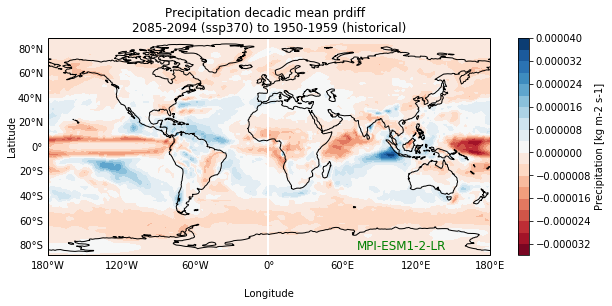

In [5]:


# chose one of the ds
lons = ds_ssp['lon']
lats = ds_ssp['lat'] #x


fig = plt.figure(figsize=(10, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# average over the first 10 years
pr10=ds_his['pr'].isel(time=slice(0,10*12)).mean('time')

# from 10 yrs from backwards
pr10end=ds_ssp['pr'].isel(time=slice(240-10*12,240)).mean('time')

# difference 
prdiff = pr10 - pr10end

# argumente: countourf(x, y, z, zbins, 
p = plt.contourf(lons, lats, prdiff, 20,
            # transform of the projection, color map = red/blue scale for color blinds
               transform=ccrs.PlateCarree(), cmap='RdBu')

# -- label
#ax.set_xlabel('Longitude')
#ax.set_ylabel('Lattitude')

# -- per Hand
#ax.set_xticks([-180,-120,-60,0,60,120,180])
#ax.set_yticks([-90,-60,-30,0,30,60,90])


import matplotlib.ticker as mticker                                             
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER       
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)                     
gl.xlabels_top = False         
gl.ylabels_left = True                                                          
gl.ylabels_right = False                                                        
gl.xlines = False                                                               
gl.ylines = False                                                               
gl.xformatter = LONGITUDE_FORMATTER                                             
gl.yformatter = LATITUDE_FORMATTER                                              
                                                                                
ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',                      
        rotation='vertical', rotation_mode='anchor',                            
        transform=ax.transAxes)                                                 
ax.text(0.5, -0.2, 'Longitude', va='bottom', ha='center',                       
        rotation='horizontal', rotation_mode='anchor',                          
        transform=ax.transAxes)

modname='MPI-ESM1-2-LR'
ax.text(0.9, 0.01, modname,
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='green', fontsize=12)


# draw colorbar
c = plt.colorbar(p)

#print(ds_his['pr'].attrs['units'])

# for plot title
plottitle = ds_his['pr'].attrs['long_name']
c.ax.set_ylabel(plottitle + ' ['+ ds_his['pr'].attrs['units'] +']')

# string datetime
strdt =' \n2085-2094 (ssp370) to 1950-1959 (historical)'  
pname = plottitle + ' decadic mean prdiff '+ strdt 
plt.title(pname)

# save before show()
pname='/tmp/c.png'
plt.savefig(pname)


plt.show()
